# **PRÁCTICA 6:  Machine Learning - Parte 1: Decision Tree Classifier**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 3ª curso del Grado Ciencia de Datos

En esta parte vamos a hacer un clasificador utilizando bagging y árboles de decisión para clasificación. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_circles
from sklearn.datasets import load_iris, load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import metrics
from scipy.stats import mode

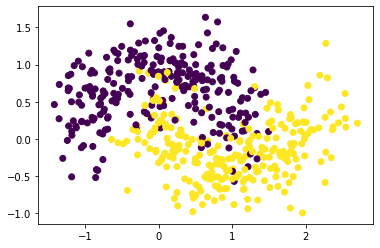

In [ ]:
# Leemos los datos y los mostramos
# Para 2 moons
X, y = make_moons(n_samples=500, noise=0.3, random_state=2)
plt.scatter(X[:,0], X[:,1], c=y);

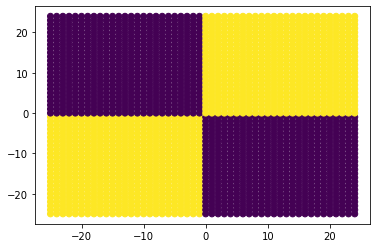

In [ ]:
# Para chessboard
N = 50
X = np.arange(N) - N/2
x1, x2 = np.meshgrid(X, X)
X = np.c_[x1.ravel(), x2.ravel()]
y = np.zeros(N * N)
y[(X[:,0] >= 0) * (X[:,1] >= 0 )] = 1
y[(X[:,0]  < 0) * (X[:,1]  < 0 )] = 1

plt.scatter(X[:,0], X[:,1], c=y);

# Clasificación de dos clases con forma peculiar para contrastar el uso de un ínico arbol con muchos árboles al mimso 
# tiempo 


In [ ]:
# Inicializamos el predictor a usar (podriamos usar otro)
predictor = DecisionTreeClassifier
criterion = 'entropy'
max_depth = 2
report = metrics.classification_report

In [ ]:
# Partimos en train y test
#  random_state lo utilizamos para tener la misma configuración de los datos para todos
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3, random_state=1234)

# SOLO UN ÁRBOL

Clasificamos usando solo un árbol

In [ ]:
# Creamos un predictor, veamos como funciona un árbol con estas carácterísticas
# Creamos el árbol:
dt = predictor(criterion=criterion, max_depth=max_depth)

In [ ]:
# entrenamos y predecimos con el predictor
dt.fit(Xtr, ytr)
yp = dt.predict(Xts)
print('Res tree:', report(yts, yp))

Res tree:               precision    recall  f1-score   support

         0.0       0.68      0.67      0.67       381
         1.0       0.66      0.68      0.67       369

    accuracy                           0.67       750
   macro avg       0.67      0.67      0.67       750
weighted avg       0.67      0.67      0.67       750



# BAGGING

### Ejercicio 1: Crea un bosque usando muchos árboles.
Para ello:

1. Decide cuantos árboles tendrá tu bosque
2. Create una lista para guardarte cada uno de los árboles
3. Crea un bucle donde
    1. Entrenes cada uno de los árboles con un subset aleatorio de tus datos muestreado con repetición
    2. Guardes el árbol entrenado

Ayuda:

- Puedes usar una variable tipo list para guardar cada árbol.
- Puedes usar la funcion `resample` para crear el subset de datos. 

In [ ]:
# Decidimos cuántos árboles tendrá tu bosque, en este caso 100 árboles.
nt = 100 
# Creamos una lista para guardar cada uno de los árboles.
tree_list = []

# Creamos un bucle donde 
for i in range(nt):
    
    # generamos el nuevo conjunto de datos usando resample, replace = True, Xtr, ytr.
    Xtr_new, ytr_new = resample(Xtr, ytr, replace = True)
    
    # Entrenamos con el nuevo conjunto de datos.
    dt = predictor(criterion='entropy', max_depth=2)
    new_tree = dt.fit(Xtr_new, ytr_new)
    
    # Añadimos el árbol entrenado a la lista creada anteriormente.
    tree_list.append(new_tree)

### Ejercicio 2: Predice en los datos de test usando la moda de lo que clasifica cada árbol para cada muestra.
Ayuda: Usa la funcion `mode`

In [ ]:
def predict_bagging(tree_list, X):
    nt = len(tree_list)
    # Cuantos elementos voy a predecir X.shape[0] y cuantas veces voy a predecir nt
    yp = np.zeros((X.shape[0],nt)) 

    for i in range(nt):
        # predecimos con cada árbol y guardamos resultados 
        yp[:,i] = tree_list[i].predict(X)
    
    # Obtenemos la moda con 'mode'
    yp, nv = mode(yp, axis = 1) #axix = 1 para que tenga en cuenta las filas en la votación
    
    return yp

# Nos devuelve los votos y el conteo (Que clase ha sido más votada (yp) y cuantos votos ha recibido cada clase (nv)).

yp = predict_bagging(tree_list, Xts)
print('Res tree:', report(yts, yp))

Res tree:               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       381
         1.0       0.95      0.96      0.96       369

    accuracy                           0.96       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750



## Fronteras de decisión árbol vs bosque

### Ejercicio 3: Compara los resultados ¿Funciona mejor el bagging?

Usa el siguiente código para comprar las fornteras de decision del árbol y el bosque

In [ ]:
%%time
npoints = 50
xr = np.linspace(-50, 50, npoints)
yr = np.linspace(-50, 50, npoints)
zt = np.zeros((npoints, npoints))
zz = zt.copy()
for i, xx in enumerate(xr):
    for j, yy in enumerate(yr):
        zt[i,j] = dt.predict(np.c_[xx,yy])
        zz[i,j] = predict_bagging(tree_list, np.c_[xx,yy])

CPU times: user 13.8 s, sys: 112 ms, total: 13.9 s
Wall time: 14 s


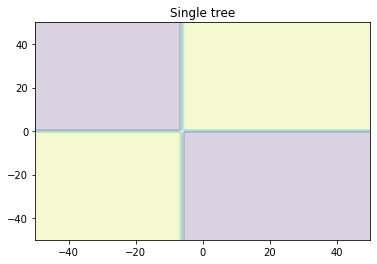

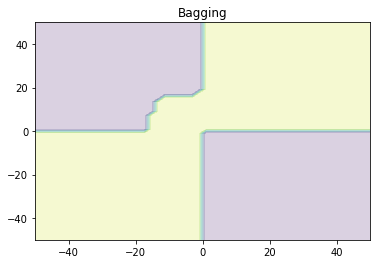

In [ ]:
xx, yy = np.meshgrid(xr, yr)
plt.figure(), plt.contourf(xx, yy, zt, alpha=0.2), plt.title('Single tree')
plt.figure(), plt.contourf(xx, yy, zz, alpha=0.2), plt.title('Bagging');

# Accuracy dependiendo del número de árboles

### Ejercicio 4: 
Evalua el algoritmo para distinto número de árboles y crea una gráfica del error frente al número de árboles ¿Se reduce el error conforme se usan más árboles?

Ayuda: Toma valores de 10 a 100 árboles en el bosque.

In [ ]:
from sklearn.metrics import accuracy_score

aciertos = []

for nt in range(10, 110, 10):

    # Creamos una lista para guardar cada uno de los árboles.
    tree_list = []

    # Creamos un bucle donde 
    for i in range(nt):

        #generamos el nuevo conjunto de datos usando resample, replace = True, Xtr, ytr.
        Xtr_new, ytr_new = resample(Xtr, ytr, replace = True)

        # Entrenamos con el nuevo conjunto de datos.
        dt = predictor(criterion='entropy', max_depth=2)
        new_tree = dt.fit(Xtr_new, ytr_new)

        # Añadimos a la lista creada anteriormente.
        tree_list.append(new_tree)
        
    # Calculamos su predicción 
    yp = dt.predict(Xts)
        
    # Aciertos 
    aciertos.append(accuracy_score(yts,yp))
        

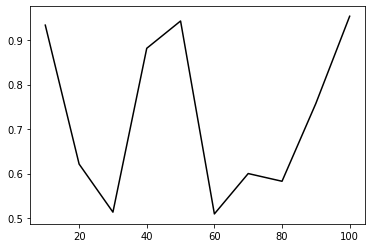

In [ ]:
plt.plot(range(10, 110, 10), aciertos, '-k')